### Introduction to PCA-Nets in TorchPhysics

This notebook contains a template for the joint exercise regarding the PCA-Nets in TorchPhysics.

We start easy and try to again learn the integral operator given by the ODE
\begin{align*}
    \partial_t u(t) &= 5.0f(t) \quad \text{ for } t \in (0, 1), \\
    u(0) &= 0.
\end{align*}
Goal is to train one network that outpus $u$ for a given $f$. 

We will use the model order reduction networks (PCA-Nets) [(paper)](https://arxiv.org/abs/2005.03180) to solve this problem.

In [1]:
# This block is for GPU selection. Please execute.
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

Still a data-driven approach, we first have to load some data.

Time discretization: 100
Available data points: 20000
Shape of data: torch.Size([20000, 100, 1])


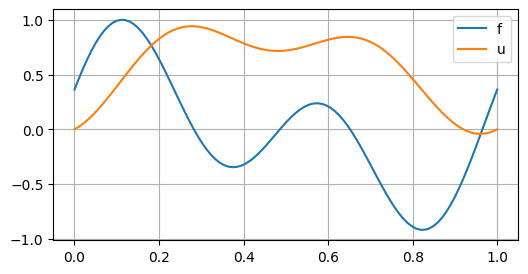

In [ ]:
save_path = "/localdata/tomfre/Data_integrator"
input_t = torch.load(f"{save_path}/input_t.pt")
input_f = torch.load(f"{save_path}/input_f.pt")
output_u = torch.load(f"{save_path}/output_u.pt")

print("Time discretization:", len(input_t))
print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

example_idx = 102
plt.figure(0, figsize=(6, 3))
plt.plot(input_t, input_f[example_idx])
plt.plot(input_t, output_u[example_idx])
plt.grid()
leg = plt.legend(["f", "u"])

Next we implement the *Spaces* that appear in the problem. Now we have additional *FunctionSpaces* defining what kind of functions appear in the problem.

In [3]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

fn_space_F = tp.spaces.FunctionSpace(T, F)
fn_space_U = tp.spaces.FunctionSpace(T, U)

We split our data into training and testing set. Such that we only train on one part of the data and afterwards can validate our model on the unseen testing set.

In [4]:
# Split data into training and testing:
total_data = len(input_f)
train_N = int(0.8*total_data) # we use 80% of the data for training

train_f = input_f[:train_N]
train_u = output_u[:train_N]

test_f = input_f[train_N:]
test_u = output_u[train_N:]

# Define FunctionSet (similar to a PyTorch DataSet) to handle data collection.
data_functionset_input = tp.domains.DataFunctionSet(fn_space_F, train_f)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_U, train_u)

In [5]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(6000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Now we define our neural network that should learn the operator. Before we used a simple FCN which we want to replace now!

In [7]:
# First we need to carry out the PCA, this can be done by the functionset-class:
data_functionset_input.compute_pca(15) # <- the number of PC to use for the input
data_functionset_output.compute_pca(15) # <- the number of PC to use for the output

In [ ]:
# We may want to analyze the basis functions and size of the principal components:
_, S, V = data_functionset_input.pca

basis_idx = 4

# Plot one example of the data
f, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].plot(S)
axarr[0].title.set_text(r"Size of principal component")
axarr[0].set_yscale("log")
axarr[0].grid()
axarr[1].plot(torch.linspace(0, 1, len(V)), V[:, basis_idx])
axarr[1].title.set_text(f"Basis function number {basis_idx}")
axarr[1].grid()
plt.tight_layout()

In [9]:
# FCN via the computed PCA:
model = tp.models.PCANN_FC.from_fn_set(
    data_functionset_input, data_functionset_output, hidden=(20, 20)
)

In [10]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

Start the training. Where we now also add a *learning rate scheduler* to decrease the learning rate after a given number of steps.

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.25})

# As before define the solver and trainer:
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=20000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)


Finally, we check the performance on the test data (which the model has not seen before!).

In [12]:
model_output = model(test_f).as_tensor.detach()
rel_error = torch.max(torch.abs(model_output - test_u)) / torch.max(torch.abs(test_u))
print(f"Relative error on test data: {rel_error*100} %")

Relative error on test data: 8.153542518615723 %


We can also visualize the performance:

In [ ]:
print("Example plot:")
plot_idx = 20
f, axarr = plt.subplots(1,2, figsize=(9, 2.5))
axarr[0].plot(input_t, test_f[plot_idx])
axarr[0].title.set_text(r"Example $f$")
axarr[0].grid()
axarr[1].plot(input_t, test_u[plot_idx])
axarr[1].plot(input_t, model_output[plot_idx], linestyle="--")
axarr[1].title.set_text(r"Solution $u$")
axarr[1].grid()
leg = axarr[1].legend(["True solution", "Predicted solution"])